In [2]:
!unzip /content/underwater_dataset.zip

Archive:  /content/underwater_dataset.zip
   creating: underwater_dataset/
   creating: underwater_dataset/train/
   creating: underwater_dataset/train/degraded/
  inflating: underwater_dataset/train/degraded/0.jpg  
  inflating: underwater_dataset/train/degraded/1.jpg  
  inflating: underwater_dataset/train/degraded/2.jpg  
  inflating: underwater_dataset/train/degraded/3.jpg  
  inflating: underwater_dataset/train/degraded/4.jpg  
  inflating: underwater_dataset/train/degraded/5.jpg  
  inflating: underwater_dataset/train/degraded/6.jpg  
  inflating: underwater_dataset/train/degraded/7.jpg  
  inflating: underwater_dataset/train/degraded/8.jpg  
  inflating: underwater_dataset/train/degraded/9.jpg  
  inflating: underwater_dataset/train/degraded/10.jpg  
  inflating: underwater_dataset/train/degraded/11.jpg  
  inflating: underwater_dataset/train/degraded/12.jpg  
  inflating: underwater_dataset/train/degraded/13.jpg  
  inflating: underwater_dataset/train/degraded/14.jpg  
  inflat

In [3]:
!pip install timm lpips pytorch_msssim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
import os
import timm
import matplotlib.pyplot as plt

# ---------------------------
# Device Setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# U-Transformer with Skip Connections
# ---------------------------
class UTransformer(nn.Module):
    def __init__(self):
        super(UTransformer, self).__init__()
        self.encoder = timm.create_model("vit_base_patch8_224", pretrained=True, num_classes=0)

        # ViT base has 768 channels; with patch size 8, feature map is 28x28 (224/8)
        self.up1 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)  # 28 -> 56
        self.up2 = nn.ConvTranspose2d(384 + 384, 192, kernel_size=2, stride=2)  # 56 -> 112
        self.up3 = nn.ConvTranspose2d(192 + 192, 96, kernel_size=2, stride=2)   # 112 -> 224
        self.final_conv = nn.Conv2d(96, 3, kernel_size=1)

    def forward(self, x):
        x = self.encoder.forward_features(x)  # (B, N, C)
        B, N, C = x.shape
        x = x[:, 1:, :]  # remove CLS token
        H = W = int((N) ** 0.5)  # Patch8 -> 28x28 = 784 tokens
        x = x.permute(0, 2, 1).contiguous().view(B, C, H, W)

        skip1 = x
        x = self.up1(x)             # 28 -> 56
        skip2 = x
        x = self.up2(torch.cat([x, skip2], dim=1))  # 56 -> 112
        skip3 = x
        x = self.up3(torch.cat([x, skip3], dim=1))  # 112 -> 224
        x = self.final_conv(x)
        x = torch.sigmoid(x)
        return x


# ---------------------------
# Perceptual Loss using VGG16
# ---------------------------
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        return_nodes = {'features.16': 'feat'}
        self.feat_extractor = create_feature_extractor(vgg, return_nodes=return_nodes).to(device)
        for param in self.feat_extractor.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_feat = self.feat_extractor(x)['feat']
        y_feat = self.feat_extractor(y)['feat']
        return F.mse_loss(x_feat, y_feat)

# ---------------------------
# SSIM Loss
# ---------------------------
def ssim_loss(x, y):
    from pytorch_msssim import ssim
    return 1 - ssim(x, y, data_range=1.0, size_average=True)

# ---------------------------
# Dataset
# ---------------------------
class UnderwaterDataset(Dataset):
    def __init__(self, degraded_dir, clear_dir, transform=None):
        self.degraded_dir = degraded_dir
        self.clear_dir = clear_dir
        self.transform = transform
        self.degraded_images = sorted(os.listdir(degraded_dir))
        self.clear_images = sorted(os.listdir(clear_dir))

    def __len__(self):
        return len(self.degraded_images)

    def __getitem__(self, idx):
        degraded = Image.open(os.path.join(self.degraded_dir, self.degraded_images[idx])).convert("RGB")
        clear = Image.open(os.path.join(self.clear_dir, self.clear_images[idx])).convert("RGB")
        if self.transform:
            degraded = self.transform(degraded)
            clear = self.transform(clear)
        return degraded, clear

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = UnderwaterDataset("/content/underwater_dataset/train/degraded",
                                  "/content/underwater_dataset/train/clear", transform)
test_dataset = UnderwaterDataset("/content/underwater_dataset/test/degraded",
                                 "/content/underwater_dataset/test/clear", transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# ---------------------------
# Model, Loss, Optimizer
# ---------------------------
model = UTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
mse_loss = nn.MSELoss()
percep_loss = PerceptualLoss()

# Combined Loss

def combined_loss(pred, target):
    l1 = mse_loss(pred, target)
    l2 = percep_loss(pred, target)
    l3 = ssim_loss(pred, target)
    return l1 + 0.1 * l2 + 0.5 * l3

# ---------------------------
# Training
# ---------------------------
def train_model(epochs=15):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for degraded, clear in train_loader:
            degraded, clear = degraded.to(device), clear.to(device)
            optimizer.zero_grad()
            outputs = model(degraded)
            loss = combined_loss(outputs, clear)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

train_model()



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 170MB/s]


Epoch [1/15], Loss: 0.8490
Epoch [2/15], Loss: 0.7770
Epoch [3/15], Loss: 0.6674
Epoch [4/15], Loss: 0.5423
Epoch [5/15], Loss: 0.4175
Epoch [6/15], Loss: 0.3464
Epoch [7/15], Loss: 0.2900
Epoch [8/15], Loss: 0.2438
Epoch [9/15], Loss: 0.2236
Epoch [10/15], Loss: 0.1980
Epoch [11/15], Loss: 0.1962
Epoch [12/15], Loss: 0.1803
Epoch [13/15], Loss: 0.1591
Epoch [14/15], Loss: 0.1401
Epoch [15/15], Loss: 0.1320


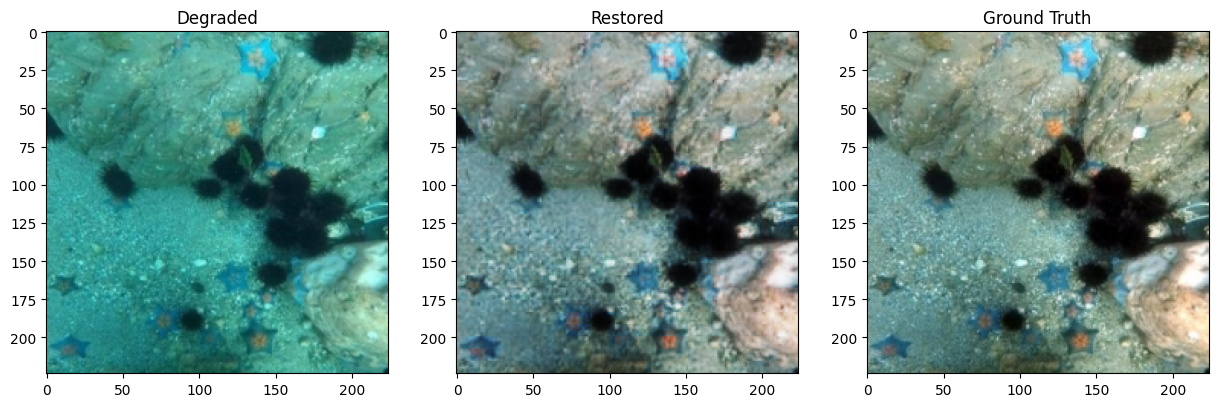

In [5]:
# ---------------------------
# Testing
# ---------------------------
def test_model():
    model.eval()
    with torch.no_grad():
        for degraded, clean in test_loader:
            degraded = degraded.to(device)
            clean = clean.to(device)
            outputs = model(degraded)

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(degraded[0].permute(1, 2, 0).cpu().numpy())
            axes[0].set_title("Degraded")
            axes[1].imshow(outputs[0].permute(1, 2, 0).cpu().numpy())
            axes[1].set_title("Restored")
            axes[2].imshow(clean[0].permute(1, 2, 0).cpu().numpy())
            axes[2].set_title("Ground Truth")
            plt.show()
            break

test_model()